In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os,sys,glob
from math import *
import xarray as xr
import pickle
import pytz
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy import optimize

In [2]:
# Load own modules
projectname = 'EUREC4A_organization'
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
while os.path.basename(rootdir) != projectname:
    rootdir = os.path.dirname(rootdir)
repodir = rootdir
moduledir = os.path.join(repodir,'functions')
resultdir = os.path.join(repodir,'results','idealized_calculations')
figdir = os.path.join(repodir,'figures','idealized_calculations')
inputdir = '/Users/bfildier/Dropbox/Data/EUREC4A/sondes_radiative_profiles/'
resultinputdir = os.path.join(repodir,'results','radiative_features')
radinputdir = os.path.join(repodir,'input')
scriptsubdir = 'observed_moist_intrusions'

os.makedirs(os.path.join(figdir,scriptsubdir),exist_ok=True)

In [59]:
# current environment
thismodule = sys.modules[__name__]

##-- Own modules
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

#- Parameters & constants
from thermoConstants import *
from thermoFunctions import *
from matrixoperators import *
from radiativefeatures import *
from radiativescaling import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats', 'thermoFunctions', 'thermoConstants', 'radiativescaling', 'radiativefeatures', 'matrixoperators']


# Load data

In [60]:
days =          '20200122','20200124','20200126','20200128','20200131','20200202','20200205','20200207','20200209','20200211','20200213'
ref_day = '20200126'

# box of analysis
lat_box = 11,16
lon_box = -60,-52

dim_t = 0

# varids
varids = 'QRAD','QRADSW','QRADLW','QV'

mo = MatrixOperators()

###--- Load data ---###

# Profiles
radprf = xr.open_dataset(os.path.join(inputdir,'rad_profiles_CF.nc'))
# choose profiles for that day that start at bottom
data_all = radprf.where(radprf.z_min<=50,drop=True)
data_day = data_all.sel(launch_time=ref_day)

# coordinates
z = data_all.alt.values/1e3 # km
pres = np.nanmean(data_all.pressure.data,axis=dim_t)/100 # hPa

# Radiative features
rad_features_all = {}

for day in days:

    #-- Radiative features
    features_filename = 'rad_features.pickle'
    print('loading %s'%features_filename)
    # load
    features_path = os.path.join(resultinputdir,day,features_filename)
    f = pickle.load(open(features_path,'rb'))
    # store
    rad_features_all[day] = f

loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


# Create idealized profiles for 2020-02-13 highest peaks

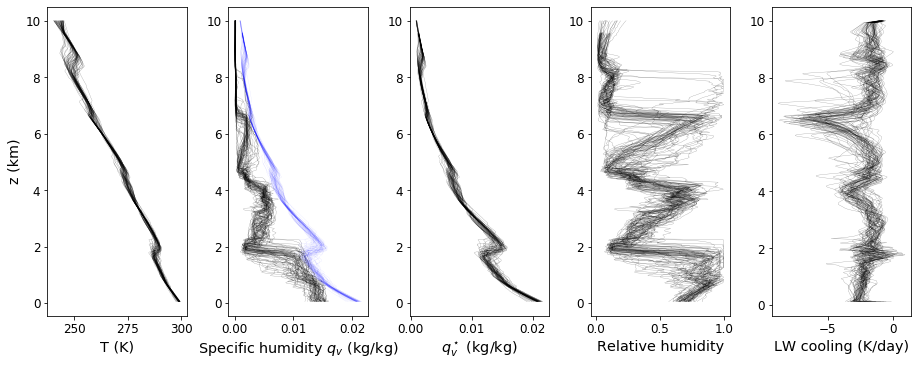

In [61]:
day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

def getProfiles(rad_features, data_day, z_min, z_max):

    #- Mask
    # |qrad| > 5 K/day
    qrad_peak = np.absolute(rad_features.qrad_lw_peak)
    keep_large = qrad_peak > 5 # K/day
    # in box
    lon_day = data_day.longitude[:,50]
    lat_day = data_day.latitude[:,50]
    keep_box = np.logical_and(lon_day < lon_box[1], lat_day >= lat_box[0])
    # high-level peak
    keep_high =  np.logical_and(rad_features.z_net_peak < z_max, # m
                                rad_features.z_net_peak > z_min)
    # combined
    k = np.logical_and(np.logical_and(keep_large,keep_box),keep_high)

    # temperature
    temp = data_day.temperature.values[k,:]
    # specific humidity
    qv = data_day.specific_humidity.values[k,:]
    # relative humidity    
    rh = data_day.relative_humidity.values[k,:]
    # lw cooling
    qradlw = rad_features.qrad_lw_smooth[k,:]

    return temp, qv, rh, qradlw


date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

fig,axs = plt.subplots(ncols=5,figsize=(16,5.5))

for i_s in range(rh.shape[0]):

    axs[0].plot(temp[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[1].plot(qv[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[1].plot(qvstar[i_s],z,c='b',linewidth=0.3,alpha=0.1)
    axs[2].plot(qvstar[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[3].plot(rh[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[4].plot(qradlw[i_s],z,c='k',linewidth=0.3,alpha=0.4)

axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[4].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

heights_label = ('btw%1.1fand%1.1fkm'%(z_min/1e3,z_max/1e3)).replace('.','p')

plt.savefig(os.path.join(figdir,scriptsubdir,'thermo_profiles_for_high_level_peaks_%s_%s.pdf'%(heights_label,day)),bbox_inches='tight')


Take median profiles


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Text(0, 0.5, 'z (km)')

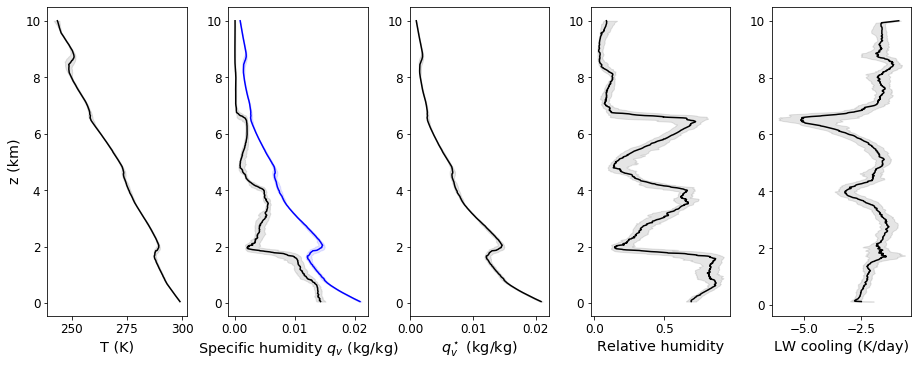

In [62]:
print('Take median profiles')

day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh


varids = 'temp','qv','qvstar','rh','qradlw'
Nv = len(varids)

# Compute quartile profiles
for varid in varids:

    # get variable
    var = getattr(thismodule,varid)
    # compute quartiles
    var_Q1, var_med, var_Q3 = np.nanpercentile(var,25,axis=0), np.nanpercentile(var,50,axis=0), np.nanpercentile(var,75,axis=0)

    for suffix in 'Q1','med','Q3':
        # reassign in current environment with correct variable name
        setattr(thismodule,'%s_%s'%(varid,suffix),getattr(thismodule,'var_%s'%suffix))



fig,axs = plt.subplots(ncols=5,figsize=(16,5.5))

for i,varid in zip(range(Nv),varids):

    # get variable
    for suffix in 'Q1','med','Q3':
        setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'%s_%s'%(varid,suffix)))

    axs[i].plot(var_med,z,c='k')
    axs[i].fill_betweenx(z,var_Q1,var_Q3,color='k',alpha=0.1)

axs[1].plot(qvstar_med,z,c='b')
axs[1].fill_betweenx(z,qvstar_Q1,qvstar_Q3,color='b',alpha=0.1)

axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[4].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# heights_label = ('btw%1.1fand%1.1fkm'%(z_min/1e3,z_max/1e3)).replace('.','p')

# plt.savefig(os.path.join(figdir,scriptsubdir,'thermo_profiles_for_high_level_peaks_%s_%s.pdf'%(heights_label,day)),bbox_inches='tight')


Idealize these profiles
T(z) = -5.7 z + 298.4, r = -0.99
ln(qvstar) = 2.5 ln(p) + -20.8, r = 0.99
alpha = 2.46, qvstar(1000hPa) = -3.85


Text(0, 0.5, 'z (km)')

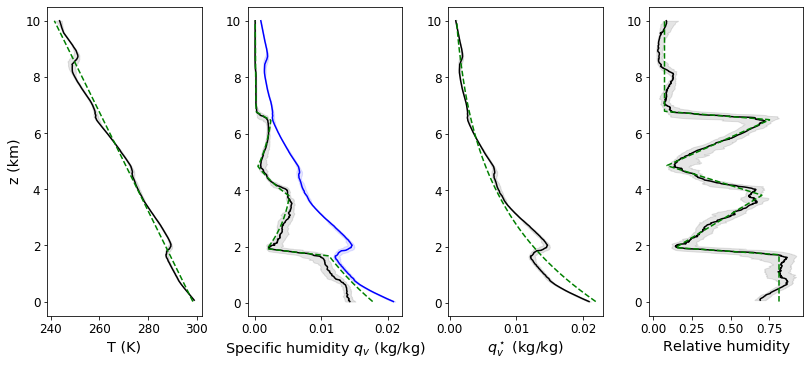

In [64]:
print('Idealize these profiles')

from scipy.stats import linregress

# Linear fit T(z)
mask = ~np.isnan(z) & ~np.isnan(temp_med)
slope, intercept, r, p, se = linregress(z[mask],temp_med[mask])
print('T(z) = %2.1f z + %3.1f, r = %1.2f'%(slope,intercept,r))
temp_id = slope*z + intercept

# power fit qvstar(p)
mask = ~np.isnan(pres) & ~np.isnan(qvstar_med)
slope, intercept, r, p, se = linregress(np.log(pres[mask]),np.log(qvstar_med[mask]))
print('ln(qvstar) = %2.1f ln(p) + %3.1f, r = %1.2f'%(slope,intercept,r))
print('alpha = %1.2f, qvstar(1000hPa) = %1.2f'%(slope,slope*np.log(1000)+intercept))
qvstar_id = np.exp(slope*np.log(pres) + intercept)

# piecewise linear fit for RH(z)
z_breaks = [1.8,2,4,5,6.5,6.8]
rh_breaks = [0.8,0.1,0.65,0.1,0.65,0.05]

def piecewise_linear(z,z_breaks,rh_breaks):
    cond_list = [z <= z_breaks[0]]+\
                [np.logical_and(z > z_breaks[i-1],z <= z_breaks[i]) for i in range(1,6)]+\
                [z > z_breaks[5]]
    def make_piece(k):
        def f(z):
            return rh_breaks[k-1]+(rh_breaks[k]-rh_breaks[k-1])/(z_breaks[k]-z_breaks[k-1])*(z-z_breaks[k-1])
        return f 
    func_list = [lambda z: rh_breaks[0]]+\
                [make_piece(k) for k in range(1,6)]+\
                [lambda z: rh_breaks[5]]
    return np.piecewise(z,cond_list,func_list)

# def piecewise_fit(z,z0,z1,z2,z3,z4,z5,rh0,rh1,rh2,rh3,rh4,rh5):
#     return piecewise_linear(z,[z0,z1,z2,z3,z4,z5],[rh0,rh1,rh2,rh3,rh4,rh5])

def piecewise_fit(z,rh,z_breaks_0,rh_breaks_0):

    N_breaks = len(z_breaks)
    
    def piecewise_fun(z,*p):
        return piecewise_linear(z,p[0:N_breaks],p[N_breaks:2*N_breaks])

    mask = ~np.isnan(z) & ~np.isnan(rh)
    p , e = optimize.curve_fit(piecewise_fun, z[mask], rh[mask],p0=z_breaks_0+rh_breaks_0)

    rh_id = piecewise_linear(z,p[0:N_breaks],p[N_breaks:2*N_breaks])
    
    return p,rh_id

p,rh_id = piecewise_fit(z,rh_med,z_breaks,rh_breaks)
    
# resulting piecewise_power qv
qv_id = rh_id*qvstar_id

Npanels = Nv-1
fig,axs = plt.subplots(ncols=Nv-1,figsize=(3.5*Npanels,5.5))

for i,varid in zip(range(Npanels),varids[:Npanels]):
    
    # does the idealized profile exist?
    id_exists = "%s_id"%varid in list(locals().keys())
    
    # get variables
    for suffix in 'Q1','med','Q3':
        setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'%s_%s'%(varid,suffix)))
        
    if id_exists:
        setattr(thismodule,'var_id',getattr(thismodule,'%s_id'%(varid)))

    axs[i].plot(var_med,z,c='k')
    axs[i].fill_betweenx(z,var_Q1,var_Q3,color='k',alpha=0.1)
    # fit
    if id_exists:
        axs[i].plot(var_id,z,c='g',linestyle='--')

axs[1].plot(qvstar_med,z,c='b')
axs[1].fill_betweenx(z,qvstar_Q1,qvstar_Q3,color='b',alpha=0.1)

axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[0].set_ylabel('z (km)')

In [65]:
p

array([1.66883978, 1.92184357, 3.78683593, 4.84246134, 6.47640954,
       6.77508558, 0.81134813, 0.14594506, 0.7024782 , 0.08932133,
       0.75291206, 0.07457219])

Flatten the transition to dry above each moisture layer


Text(0, 0.5, 'z (km)')

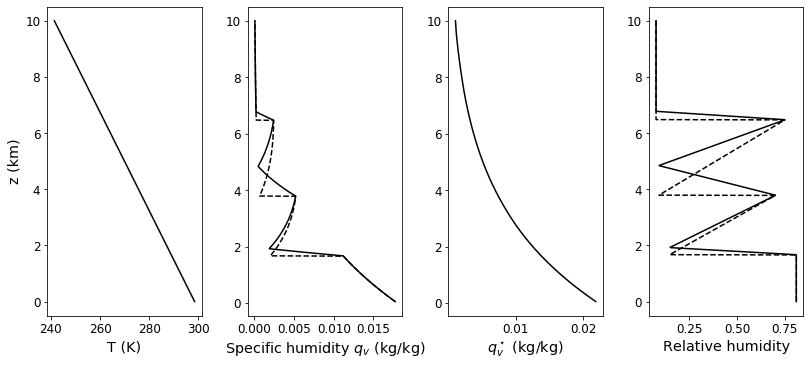

In [8]:
print('Flatten the transition to dry above each moisture layer')

# flatten rh
p_flat = p.copy()
p_flat[1] = p[0] # flatten boundary layer
p_flat[3] = p[2] # flatten lower intrusion
p_flat[5] = p[4] # flatten upper intrusion

rh_id_flat = piecewise_linear(z,p_flat[0:6],p_flat[6:12])

# resulting piecewise_power qv
qv_id_flat = rh_id_flat*qvstar_id

Npanels = Nv-1
fig,axs = plt.subplots(ncols=Nv-1,figsize=(3.5*Npanels,5.5))

for i,varid in zip(range(Npanels),varids[:Npanels]):
    
    # does the idealized profile exist?
    id_exists = "%s_id"%varid in list(locals().keys())
    flat_exists = "%s_id_flat"%varid in list(locals().keys())
    
    # get variables
    for suffix in 'Q1','med','Q3':
        setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'%s_%s'%(varid,suffix)))
        
    if id_exists:
        setattr(thismodule,'var_id',getattr(thismodule,'%s_id'%(varid)))
        
    if flat_exists:
        setattr(thismodule,'var_id_flat',getattr(thismodule,'%s_id_flat'%(varid)))

    # show fit
    if id_exists:
        axs[i].plot(var_id,z,c='k')
    # show flattened fit
    if flat_exists:
        axs[i].plot(var_id_flat,z,c='k',linestyle='--')

    
axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[0].set_ylabel('z (km)')

Remove moisture intrusions to median profiles:
_ru: "remove upper", _rl : "remove lower", _rul: "remove upper and lower"


Text(0, 0.5, 'z (km)')

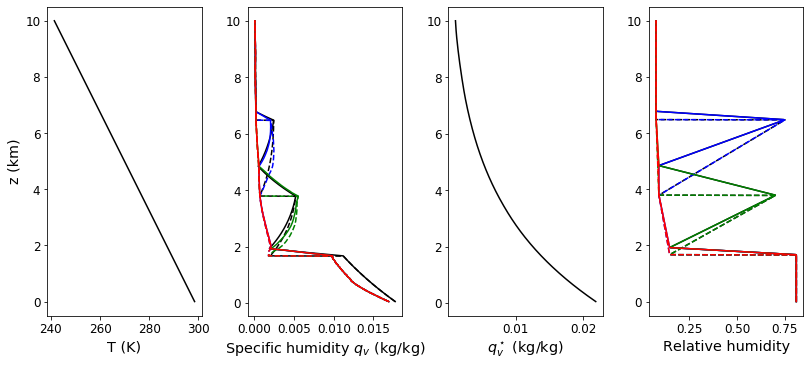

In [9]:
print('Remove moisture intrusions to median profiles:')
print('_ru: "remove upper", _rl : "remove lower", _rul: "remove upper and lower"')

def removeIntrusion(which,p):
    """Compute rh and qv profiles after removing a moisture intrusion:
    
    Arguments:
    - which: upper, lower"""
    
    Nbreaks = 6
    if which == 'upper':
        i_peaks = [Nbreaks+4]
    elif which == 'lower':
        i_peaks = [Nbreaks+2]
    elif which == 'both':
        i_peaks = [Nbreaks+2,Nbreaks+4]
    
    # update params
    p_new = p.copy()
    for i_peak in i_peaks:
        p_new[i_peak] = p_new[i_peak+1] # set rh peak value to that of the one just above

    # rh
    rh_new = piecewise_linear(z,p_new[0:6],p_new[6:12])
    # qv
    qv_new = qvstar_med*rh_new
    
    return p_new,rh_new,qv_new

# for idealized profiles
p_ru, rh_id_ru, qv_id_ru = removeIntrusion('upper',p)
p_rl, rh_id_rl, qv_id_rl = removeIntrusion('lower',p)
p_rul, rh_id_rul, qv_id_rul = removeIntrusion('both',p)

# for flattened profiles
p_flat_ru, rh_id_flat_ru, qv_id_flat_ru = removeIntrusion('upper',p_flat)
p_flat_rl, rh_id_flat_rl, qv_id_flat_rl = removeIntrusion('lower',p_flat)
p_flat_rul, rh_id_flat_rul, qv_id_flat_rul = removeIntrusion('both',p_flat)

Npanels = Nv-1
fig,axs = plt.subplots(ncols=Nv-1,figsize=(3.5*Npanels,5.5))

for i,varid in zip(range(Npanels),varids[:Npanels]):
    
    for suffix,col in zip(['','_rl','_ru','_rul'],['k','b','g','r']):
        
        # test existence
        id_exists = "%s_id%s"%(varid,suffix) in list(locals().keys())
        flat_exists = "%s_id_flat%s"%(varid,suffix) in list(locals().keys())
        
        # get variables    
        if id_exists:
            setattr(thismodule,'var_id',getattr(thismodule,'%s_id%s'%(varid,suffix)))

        if flat_exists:
            setattr(thismodule,'var_id_flat',getattr(thismodule,'%s_id_flat%s'%(varid,suffix)))
        
        # show fit
        if id_exists:
            axs[i].plot(var_id,z,c=col)
        # show flattened fit
        if flat_exists:
            axs[i].plot(var_id_flat,z,c=col,linestyle='--')

    
axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[0].set_ylabel('z (km)')



In [10]:
print('save all profiles for radiative transfer calculation')

save all profiles for radiative transfer calculation


# Load results from radiative calculation

In [45]:
rad_file = os.path.join(radinputdir,'rad_profiles_moist_intrusions_20200213.nc')
rad_file_h2oonly = os.path.join(radinputdir,'rad_profiles_moist_intrusions_20200213_h2oOnly.nc')
radprf_id = xr.open_dataset(rad_file)
radprf_h20only_id = xr.open_dataset(rad_file_h2oonly)

Dibeug


Text(0.5, 0, 'SW heating rate (K/day)')

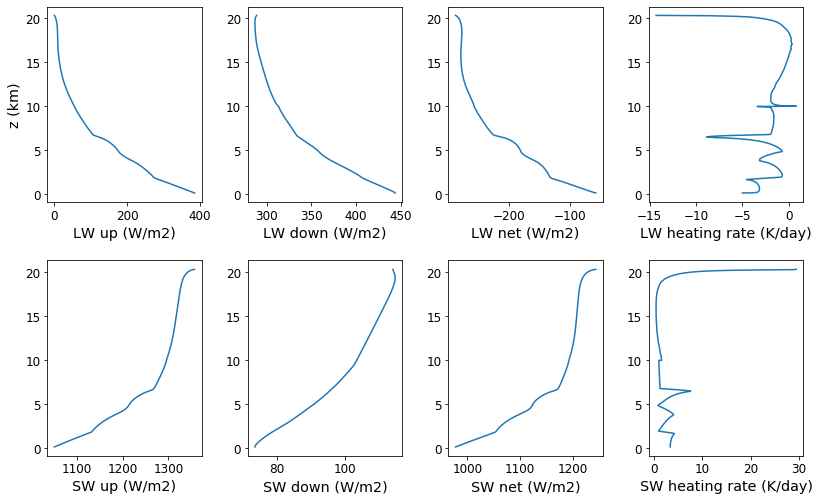

In [41]:
print('Dibeug')

fig,axs = plt.subplots(nrows=2,ncols=4,figsize=(14,8))

def smooth(values,n_smooth=1):
    return np.convolve(values,np.repeat([1/n_smooth],n_smooth),'same')

i_prof = 1
z_id = radprf_id.zlay[i_prof]/1e3

axs[0,0].plot(smooth(radprf_id.lw_dn[i_prof][:-1]),z_id)
axs[0,1].plot(smooth(radprf_id.lw_up[i_prof][:-1]),z_id)
axs[0,2].plot(smooth(radprf_id.lw_net[i_prof][:-1]),z_id)
axs[0,3].plot(smooth(radprf_id.q_rad_lw[i_prof]),z_id)
axs[1,0].plot(smooth(radprf_id.sw_dn[i_prof][:-1]),z_id)
axs[1,1].plot(smooth(radprf_id.sw_up[i_prof][:-1]),z_id)
axs[1,2].plot(smooth(radprf_id.sw_net[i_prof][:-1]),z_id)
axs[1,3].plot(smooth(radprf_id.q_rad_sw[i_prof]),z_id)

axs[0,0].set_ylabel('z (km)')
axs[0,0].set_xlabel('LW up (W/m2)')
axs[0,1].set_xlabel('LW down (W/m2)')
axs[0,2].set_xlabel('LW net (W/m2)')
axs[0,3].set_xlabel('LW heating rate (K/day)')
axs[1,0].set_xlabel('SW up (W/m2)')
axs[1,1].set_xlabel('SW down (W/m2)')
axs[1,2].set_xlabel('SW net (W/m2)')
axs[1,3].set_xlabel('SW heating rate (K/day)')

Take median profiles


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


(-10, 3)

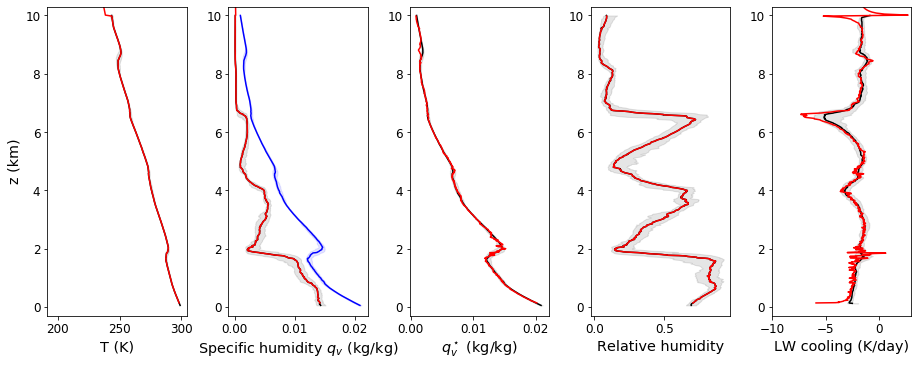

In [46]:
print('Take median profiles')

day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

varids = 'temp','qv','qvstar','rh','qradlw'

Nv = len(varids)

# Compute quartile profiles
for varid in varids:

    # get variable
    var = getattr(thismodule,varid)
    # compute quartiles
    var_Q1, var_med, var_Q3 = np.nanpercentile(var,25,axis=0), np.nanpercentile(var,50,axis=0), np.nanpercentile(var,75,axis=0)

    for suffix in 'Q1','med','Q3':
        # reassign in current environment with correct variable name
        setattr(thismodule,'%s_%s'%(varid,suffix),getattr(thismodule,'var_%s'%suffix))
    
    
    
fig,axs = plt.subplots(ncols=5,figsize=(16,5.5))

for i,varid,var_id in zip(range(Nv),varids,vars_id[1:]):
    
    # get variable
    for suffix in 'Q1','med','Q3':
        setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'%s_%s'%(varid,suffix)))

    axs[i].plot(var_med,z,c='k')
    axs[i].fill_betweenx(z,var_Q1,var_Q3,color='k',alpha=0.1)
    axs[i].plot(var_id,vars_id[0],c='r')
    axs[i].set_ylim((-0.3,10.3))
    
# axs[4].plot(qradlw_h2oonly_med,z,'r--')

axs[1].plot(qvstar_med,z,c='b')
axs[1].fill_betweenx(z,qvstar_Q1,qvstar_Q3,color='b',alpha=0.1)

axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[4].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

axs[4].set_xlim((-10,3))

# heights_label = ('btw%1.1fand%1.1fkm'%(z_min/1e3,z_max/1e3)).replace('.','p')

# plt.savefig(os.path.join(figdir,scriptsubdir,'thermo_profiles_for_high_level_peaks_%s_%s.pdf'%(heights_label,day)),bbox_inches='tight')


Flattening moist layers


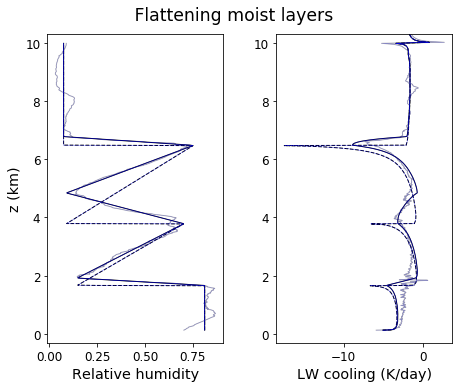

In [48]:
print('Flattening moist layers')

day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

varids = 'rh','qradlw'
Nv = len(varids)

def getIdealizedProf(radprf_id,i_id):
    
    z_id = radprf_id.zlay[i_id]/1e3
    rh_id = radprf_id.rh[i_id]
    qradlw_id = radprf_id.q_rad_lw[i_id]
    
    return z_id,rh_id,qradlw_id

i_med = 0
i_id1 = 1
i_id2 = 5

radprf_all = radprf_id,radprf_h20only_id
col_all = 'k','b'
linewidth_all = 1,0.4

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))
for radprf_xr,col,linewidth in zip(radprf_all,col_all,linewidth_all):

    vars_med = getIdealizedProf(radprf_id,i_med)
    vars_id1 = getIdealizedProf(radprf_id,i_id1)
    vars_id2 = getIdealizedProf(radprf_id,i_id2)
    Nv = len(varids)

    for i,var_med,var_id1,var_id2 in zip(range(Nv),vars_med[1:],vars_id1[1:],vars_id2[1:]):

        axs[i].plot(var_med,vars_med[0],c=col,linewidth=linewidth,alpha=0.3)
        axs[i].plot(var_id1,vars_id1[0],c=col,linewidth=linewidth)
        axs[i].plot(var_id2,vars_id2[0],c=col,linewidth=linewidth,linestyle='--')
        axs[i].set_ylim((-0.3,10.3))

axs[0].set_xlabel('Relative humidity')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# axs[1].set_xlim((-10,3))
plt.suptitle('       Flattening moist layers')

plt.savefig(os.path.join(figdir,scriptsubdir,'flattening_the_moist_layers.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'flattening_the_moist_layers.png'),bbox_inches='tight')

Removing the upper layer


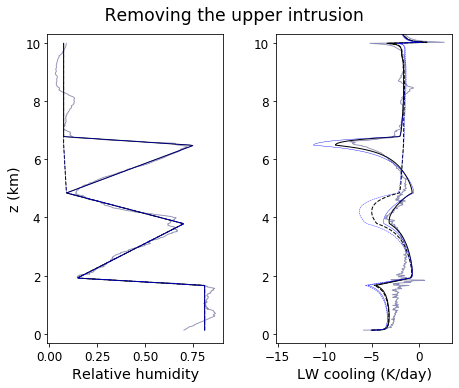

In [56]:
print('Removing the upper layer')

day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

varids = 'rh','qradlw'

def getIdealizedProf(radprf_id,i_id):
    
    z_id = radprf_id.zlay[i_id]/1e3
    rh_id = radprf_id.rh[i_id]
    qradlw_id = radprf_id.q_rad_lw[i_id]
    
    return z_id,rh_id,qradlw_id

i_med = 0
i_id1 = 1
i_id2 = 3

radprf_all = radprf_id,radprf_h20only_id
col_all = 'k','b'
linewidth_all = 1,0.4

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))
for radprf_xr,col,linewidth in zip(radprf_all,col_all,linewidth_all):

    vars_med = getIdealizedProf(radprf_xr,i_med)
    vars_id1 = getIdealizedProf(radprf_xr,i_id1)
    vars_id2 = getIdealizedProf(radprf_xr,i_id2)
    Nv = len(varids)

    for i,var_med,var_id1,var_id2 in zip(range(Nv),vars_med[1:],vars_id1[1:],vars_id2[1:]):

        axs[i].plot(var_med,vars_med[0],c=col,linewidth=linewidth,alpha=0.3)
        axs[i].plot(var_id1,vars_id1[0],c=col,linewidth=linewidth)
        axs[i].plot(var_id2,vars_id2[0],c=col,linewidth=linewidth,linestyle='--')
        axs[i].set_ylim((-0.3,10.3))

axs[0].set_xlabel('Relative humidity')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# axs[1].set_xlim((-10,3))
plt.suptitle('       Removing the upper intrusion')

plt.savefig(os.path.join(figdir,scriptsubdir,'removing_upper_intrusion.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'removing_upper_intrusion.png'),bbox_inches='tight')

Removing both intrusions


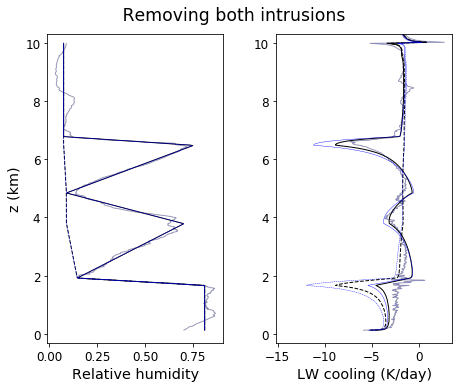

In [53]:
print('Removing both intrusions')

day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

varids = 'rh','qradlw'

def getIdealizedProf(radprf_id,i_id):
    
    z_id = radprf_id.zlay[i_id]/1e3
    rh_id = radprf_id.rh[i_id]
    qradlw_id = radprf_id.q_rad_lw[i_id]
    
    return z_id,rh_id,qradlw_id

i_med = 0
i_id1 = 1
i_id2 = 4

radprf_all = radprf_id,radprf_h20only_id
col_all = 'k','b'
linewidth_all = 1,0.4

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))
for radprf_xr,col,linewidth in zip(radprf_all,col_all,linewidth_all):

    vars_med = getIdealizedProf(radprf_xr,i_med)
    vars_id1 = getIdealizedProf(radprf_xr,i_id1)
    vars_id2 = getIdealizedProf(radprf_xr,i_id2)
    Nv = len(varids)

    for i,var_med,var_id1,var_id2 in zip(range(Nv),vars_med[1:],vars_id1[1:],vars_id2[1:]):

        axs[i].plot(var_med,vars_med[0],c=col,linewidth=linewidth,alpha=0.3)
        axs[i].plot(var_id1,vars_id1[0],c=col,linewidth=linewidth)
        axs[i].plot(var_id2,vars_id2[0],c=col,linewidth=linewidth,linestyle='--')
        axs[i].set_ylim((-0.3,10.3))

axs[0].set_xlabel('Relative humidity')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# axs[1].set_xlim((-10,3))
plt.suptitle('       Removing both intrusions')

plt.savefig(os.path.join(figdir,scriptsubdir,'removing_both_intrusions.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'removing_both_intrusions.png'),bbox_inches='tight')

Removing the upper layer


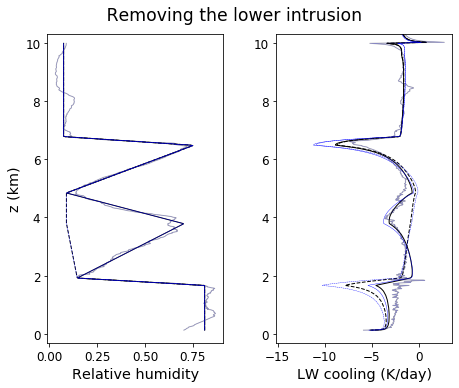

In [54]:
print('Removing the upper layer')

day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

varids = 'rh','qradlw'

def getIdealizedProf(radprf_id,i_id):
    
    z_id = radprf_id.zlay[i_id]/1e3
    rh_id = radprf_id.rh[i_id]
    qradlw_id = radprf_id.q_rad_lw[i_id]
    
    return z_id,rh_id,qradlw_id

i_med = 0
i_id1 = 1
i_id2 = 2

radprf_all = radprf_id,radprf_h20only_id
col_all = 'k','b'
linewidth_all = 1,0.4

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))
for radprf_xr,col,linewidth in zip(radprf_all,col_all,linewidth_all):

    vars_med = getIdealizedProf(radprf_xr,i_med)
    vars_id1 = getIdealizedProf(radprf_xr,i_id1)
    vars_id2 = getIdealizedProf(radprf_xr,i_id2)
    Nv = len(varids)

    for i,var_med,var_id1,var_id2 in zip(range(Nv),vars_med[1:],vars_id1[1:],vars_id2[1:]):

        axs[i].plot(var_med,vars_med[0],c=col,linewidth=linewidth,alpha=0.3)
        axs[i].plot(var_id1,vars_id1[0],c=col,linewidth=linewidth)
        axs[i].plot(var_id2,vars_id2[0],c=col,linewidth=linewidth,linestyle='--')
        axs[i].set_ylim((-0.3,10.3))
        
axs[0].set_xlabel('Relative humidity')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# axs[1].set_xlim((-10,3))
plt.suptitle('       Removing the lower intrusion')

plt.savefig(os.path.join(figdir,scriptsubdir,'removing_lower_intrusion.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'removing_lower_intrusion.png'),bbox_inches='tight')

Removing the upper layer


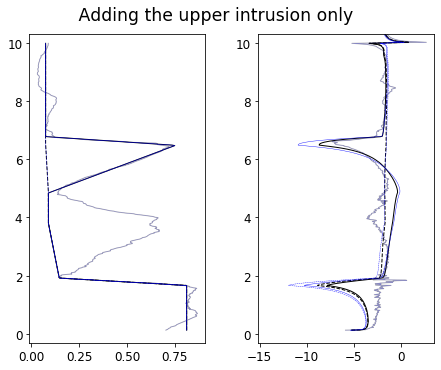

In [55]:
print('Removing the upper layer')

day = '20200213'
z_min = 5000 # m
z_max = 9000 # m

date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

varids = 'rh','qradlw'

def getIdealizedProf(radprf_id,i_id):
    
    z_id = radprf_id.zlay[i_id]/1e3
    rh_id = radprf_id.rh[i_id]
    qradlw_id = radprf_id.q_rad_lw[i_id]
    
    return z_id,rh_id,qradlw_id

i_med = 0
i_id1 = 2
i_id2 = 4

radprf_all = radprf_id,radprf_h20only_id
col_all = 'k','b'
linewidth_all = 1,0.4

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))
for radprf_xr,col,linewidth in zip(radprf_all,col_all,linewidth_all):

    vars_med = getIdealizedProf(radprf_xr,i_med)
    vars_id1 = getIdealizedProf(radprf_xr,i_id1)
    vars_id2 = getIdealizedProf(radprf_xr,i_id2)
    Nv = len(varids)

    for i,var_med,var_id1,var_id2 in zip(range(Nv),vars_med[1:],vars_id1[1:],vars_id2[1:]):

        axs[i].plot(var_med,vars_med[0],c=col,linewidth=linewidth,alpha=0.3)
        axs[i].plot(var_id1,vars_id1[0],c=col,linewidth=linewidth)
        axs[i].plot(var_id2,vars_id2[0],c=col,linewidth=linewidth,linestyle='--')
        axs[i].set_ylim((-0.3,10.3))

# axs[1].set_xlim((-10,3))
plt.suptitle('       Adding the upper intrusion only')

plt.savefig(os.path.join(figdir,scriptsubdir,'adding_upper_intrusion.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'adding_upper_intrusion.png'),bbox_inches='tight')